In [1]:
import pandas as pd
import numpy as np
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Importing

In [2]:
realtor_df = pd.read_csv('Scraping/Apify/dataset_realtor-scraper_2023-10-24_03-48-17-555.csv')
realtor_df.head()

,address/locality,address/postalCode,address/region,address/street,baths,baths_3qtr,baths_full,baths_half,baths_max,baths_min,...,taxHistory/12/market/total,taxHistory/12/tax,taxHistory/12/year,text,type,units,url,year_built,year_renovated,zoning
0,Ithaca,14850,NY,809 S Aurora St,2.0,NaN,1.0,1.0,NaN,NaN,...,140000.0,3143.0,2009.0,- (RLNE6928946) 5 bedroom walking distance to ...,single_family,1.0,https://www.realtor.com/realestateandhomes-det...,NaN,NaN,NaN
1,Ithaca,14850,NY,419 Triphammer Rd,2.0,NaN,2.0,NaN,NaN,NaN,...,300000.0,9010.0,2009.0,"Location, Location! Spacious Ithaca, Village o...",single_family,NaN,https://www.realtor.com/realestateandhomes-det...,1956.0,NaN,NaN
2,Ithaca,14850,NY,517 S Aurora St,2.0,NaN,2.0,NaN,NaN,NaN,...,195000.0,4410.0,2009.0,- (RLNE6124254) 517 S Aurora Street - Fantasti...,single_family,1.0,https://www.realtor.com/realestateandhomes-det...,NaN,NaN,NaN
3,Ithaca,14850,NY,3 Hudson Pl,1.0,NaN,1.0,NaN,NaN,NaN,...,175000.0,3969.0,2009.0,Spacious lower level 2 bedroom apartment on So...,single_family,NaN,https://www.realtor.com/realestateandhomes-det...,NaN,NaN,NaN
4,Ithaca,14850,NY,600 Warren Rd Apt 4-2,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,Warren Wood is a Ithaca Apartment located at 6...,apartment,181.0,https://www.realtor.com/realestateandhomes-det...,NaN,NaN,NaN


In [3]:
list(realtor_df.columns)

['address/locality',
 'address/postalCode',
 'address/region',
 'address/street',
 'baths',
 'baths_3qtr',
 'baths_full',
 'baths_half',
 'baths_max',
 'baths_min',
 'baths_partial_calc',
 'baths_total',
 'beds',
 'beds_max',
 'beds_min',
 'construction',
 'cooling',
 'coordinates/latitude',
 'coordinates/longitude',
 'details/0/category',
 'details/0/parent_category',
 'details/0/text/0',
 'details/0/text/1',
 'details/0/text/2',
 'details/0/text/3',
 'details/0/text/4',
 'details/0/text/5',
 'details/0/text/6',
 'details/0/text/7',
 'details/0/text/8',
 'details/0/text/9',
 'details/0/text/10',
 'details/0/text/11',
 'details/0/text/12',
 'details/0/text/13',
 'details/0/text/14',
 'details/0/text/15',
 'details/0/text/16',
 'details/0/text/17',
 'details/0/text/18',
 'details/0/text/19',
 'details/0/text/20',
 'details/0/text/21',
 'details/0/text/22',
 'details/0/text/23',
 'details/0/text/25',
 'details/0/text/26',
 'details/0/text/27',
 'details/0/text/28',
 'details/0/text/29',


In [4]:
realtor_df.isna().sum()

address/locality        0
address/postalCode      0
address/region          0
address/street          0
baths                 100
                     ... 
units                  71
url                     0
year_built            207
year_renovated        234
zoning                234
Length: 506, dtype: int64

# Cleaning

## Dealing with missing values

### Filling missing `baths` and `beds` data

In [5]:
def fill_miss_baths_beds(row):
    """ 
    Fills missing baths and beds information from 
    max and min information of a Series
    
    Input: pd.Series containing `baths`, `beds`, 
    `baths_max`, `baths_min`, `beds_max`, `beds_min` 
    index labels.

    Check if `baths` or `beds` is missing data. 
    If it is missing, find the average of the max and min
    and fill the baths and beds with the average
    if the max and min are missing, fill in the 0

    Returns pd.Series with filled beds and bath data
    """
    if pd.isna(row.loc['baths']):
        if (not(pd.isna(row.loc['baths_max'])) 
            and not(pd.isna(row.loc['baths_min']))):
            row.loc['baths'] = (row.loc['baths_max'] + 
                                row.loc['baths_min']) / 2
        else:
            row.loc['baths'] = 0
    if pd.isna(row.loc['beds']):
        if (not(pd.isna(row.loc['beds_max'])) 
            and not(pd.isna(row.loc['beds_min']))):
            row.loc['beds'] = (row.loc['beds_max'] + 
                               row.loc['beds_min']) / 2
        else:
            row.loc['beds'] = 0
    return row

realtor_changed_df = \
    realtor_df.apply(fill_miss_baths_beds, axis=1, by_row='compat')

realtor_changed_df = \
    realtor_changed_df.drop(['baths_3qtr','baths_full','baths_half',
                              'baths_max','baths_min','baths_total',
                              'baths_partial_calc',
                              'beds_max','beds_min'], axis=1)

In [6]:
realtor_changed_df[['baths','beds']].isna().sum()

baths    0
beds     0
dtype: int64

### Filling missing `garage` data

In [7]:
def fill_miss_garage(row):
    """ 
    Fills missing garage information from 
    max and min information of a Series
    
    Input: pd.Series containing `garage`, 
    `garage_max`, `garage_min` index labels.

    Check if `garage` is missing data. 
    If it is missing, find the average of the max and min
    and fill the garage with the average
    if the max and min are missing, fill in 0

    Returns pd.Series with filled garage data
    """
    if pd.isna(row.loc['garage']):
        if (not(pd.isna(row.loc['garage_max'])) 
            and not(pd.isna(row.loc['garage_min']))):
            row.loc['garage'] = (row.loc['garage_max'] + 
                                row.loc['garage_min']) / 2
        else:
            row.loc['garage'] = 0
    return row

realtor_changed_df = \
    realtor_changed_df.apply(fill_miss_garage, axis=1, by_row='compat')

realtor_changed_df = \
    realtor_changed_df.drop(['garage_max','garage_min','garage_type'], axis=1)

In [8]:
realtor_changed_df[['garage']].isna().sum()

garage    0
dtype: int64

### Filling missing `sqft` Data

In [9]:
def fill_miss_sqft(row):
    """ 
    Fills missing sqft information from 
    max and min information of a Series
    
    Input: pd.Series containing `sqft`, 
    `sqft_max`, `sqft_min` index labels.

    Check if `sqft` is missing data. 
    If it is missing, find the average of the max and min
    and fill the sqft with the average
    if the max and min are missing, fill in 0

    Returns pd.Series with filled sqft data
    """
    if pd.isna(row.loc['sqft']):
        if (not(pd.isna(row.loc['sqft_max'])) 
            and not(pd.isna(row.loc['sqft_min']))):
            row.loc['sqft'] = (row.loc['sqft_max'] + 
                                row.loc['sqft_min']) / 2
        else:
            row.loc['sqft'] = 0
    return row

realtor_changed_df = \
    realtor_changed_df.apply(fill_miss_sqft, axis=1, by_row='compat')

realtor_changed_df = \
    realtor_changed_df.drop(['sqft_max','sqft_min','lot_sqft'], axis=1)

In [10]:
realtor_changed_df[['sqft']].isna().sum()

sqft    0
dtype: int64

### Filling missing `listPrice` data

In [11]:
realtor_changed_df[['listPrice']].isna().sum()

listPrice    100
dtype: int64

In [12]:
realtor_changed_df[['listPrice','history/0/date',
 'history/0/event_name',
 'history/0/listing',
 'history/0/price',
 'history/0/price_sqft',
 'history/0/source_listing_id',
 'history/0/source_name',
 'history/1/date',
 'history/1/event_name',
 'history/1/listing',
 'history/1/price',
 'history/1/price_sqft',
 'history/1/source_listing_id',
 'history/1/source_name',]].head()

,listPrice,history/0/date,history/0/event_name,history/0/listing,history/0/price,history/0/price_sqft,history/0/source_listing_id,history/0/source_name,history/1/date,history/1/event_name,history/1/listing,history/1/price,history/1/price_sqft,history/1/source_listing_id,history/1/source_name
0,2625.0,2023-09-21,Listed for rent,NaN,2625.0,2.019231,6928946,RentlinxUnits,2022-10-14,Listing removed,NaN,0.0,NaN,47380816,Zumper
1,5000.0,2023-08-30,Listed for rent,NaN,5000.0,1.562500,H6254757,OneKeyMLS,2023-06-29,Listing removed,NaN,4800.0,1.500000,H6254757,OneKeyMLS
2,4350.0,2023-10-19,Price Changed for rent,NaN,4350.0,1.770452,6124254,RentlinxUnits,2023-09-13,Listed for rent,NaN,4800.0,1.953602,6124254,RentlinxUnits
3,1600.0,2023-10-16,Listed for rent,NaN,1600.0,1.777778,60167274,Avail,2022-01-05,Sold,NaN,350000.0,NaN,404549,IthacaNY
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def fill_miss_listPrice(row):
    """ 
    Fills missing listPrice information from 
    historical information of a Series
    
    Input: pd.Series containing `listPrice`, 
    `history/i/event_name`, `history/i/price`
    index labels. 

    Check if `listPrice` is missing data. 
    If it is missing, find the average of the max and min
    and fill the listPrice with the average
    if the max and min are missing, fill in 0

    Returns pd.Series with filled listPrice data
    """
    if pd.isna(row.loc['listPrice']):
        for i in range(12):
            var_event_name = 'history/'+str(i)+'/event_name'
            var_price = 'history/'+str(i)+'/price'
            if ((row.loc[var_event_name] == 'Listed for rent' 
                 or row.loc[var_event_name] == 'Price Changed for rent')
                and not pd.isna(row.loc[var_price])):
                row.loc['listPrice'] = row.loc[var_price]
                break
    return row

realtor_changed_df = \
    realtor_changed_df.apply(fill_miss_listPrice, axis=1, by_row='compat')

In [14]:
realtor_changed_df[['listPrice']].isna().sum()

listPrice    77
dtype: int64

In [15]:
list(realtor_changed_df[realtor_changed_df[['listPrice']].isna().any(axis=1)]\
    ['address/street'])

['600 Warren Rd Apt 4-2',
 '601 Winston Ct Apt 1',
 '37 Uptown Rd Apt 16D',
 '918 Danby Rd',
 'Ithaca Solar Townhouses',
 '700 Warren Rd # 18-2',
 '607 S Aurora St',
 '815 S Aurora St',
 '217 Columbia St',
 '2250 N Triphammer Rd Apt K2',
 '1 Candlewyck Dr',
 '106-112 S Quarry St',
 '605 S Aurora St',
 '301 E State St',
 '321-321 5 Hillview Pl # 321HIL',
 '924 Danby Rd',
 'Ithaca Solar Townhouses',
 '113 N Quarry St',
 'Coddington and Hudson Pl',
 '210 Delaware Ave',
 '108 E State St',
 '521 E State St',
 'Ithaca Solar Townhouses',
 '140 Seneca Way',
 '105 Highland Pl',
 '319 Hillview Pl # 319HIL',
 '430 W State St',
 '213-215 Columbia St',
 '711 E Seneca St',
 '718 Hudson St',
 '109 Williams St',
 '1005 1007 N Aurora St',
 '404 University Ave',
 '308 E Seneca St',
 '707 E Seneca St',
 '232 S Geneva St',
 '230 Bryant Ave',
 '226 Bryant Ave',
 '416 Hudson St # 416HUD',
 '518 Linn St',
 '128 Sapsucker Woods Rd',
 '102 Wiedmaier Ct',
 '107-109 Hudson St # 107HUD',
 '1002 N Aurora St',
 '11

In [23]:
realtor_changed_df.loc[realtor_changed_df['address/street']==\
                        'Ithaca Solar Townhouses',
                        'listPrice']=2350
realtor_changed_df.loc[realtor_changed_df['address/street']==\
                        'Ithaca Solar Townhouses',
                        'listPrice']=2350

In [ ]:
realtor_changed_df[['listPrice']].isna().sum()

### Filling missing `units` and `stories` data

In [16]:
realtor_changed_df['units'] = realtor_changed_df['units'].fillna(1)
realtor_changed_df['stories'] = realtor_changed_df['stories'].fillna(1)
realtor_changed_df[['units','stories']].isna().sum()

units      0
stories    0
dtype: int64

## Dropping irrelevant columns

In [17]:
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('details', case=False)] 
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('tax', case=False)] 
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('local', case=False)] 
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('nearbySchools', case=False)] 
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('neighborhood', case=False)] 
realtor_changed_df = realtor_changed_df.loc[:,~realtor_changed_df.columns.str.contains('history', case=False)] 
list(realtor_changed_df.columns)

['address/postalCode',
 'address/region',
 'address/street',
 'baths',
 'beds',
 'construction',
 'cooling',
 'coordinates/latitude',
 'coordinates/longitude',
 'exterior',
 'fireplace',
 'garage',
 'heating',
 'id',
 'lastSoldPrice',
 'listPrice',
 'logo',
 'name',
 'pool',
 'roofing',
 'rooms',
 'soldOn',
 'sqft',
 'status',
 'stories',
 'styles',
 'sub_type',
 'text',
 'type',
 'units',
 'url',
 'year_built',
 'year_renovated',
 'zoning']

In [18]:
realtor_changed_df = realtor_changed_df.drop(['construction','cooling','exterior',
                                              'logo','fireplace','url','text',
                                              'address/postalCode','address/region',
                                              'zoning','sub_type','styles',
                                              'rooms','roofing','pool','heating',
                                              'lastSoldPrice','soldOn','year_renovated'], 
                                             axis=1)
list(realtor_changed_df.columns)

['address/street',
 'baths',
 'beds',
 'coordinates/latitude',
 'coordinates/longitude',
 'garage',
 'id',
 'listPrice',
 'name',
 'sqft',
 'status',
 'stories',
 'type',
 'units',
 'year_built']

In [19]:
realtor_changed_df[['year_built']].isna().sum()

year_built    207
dtype: int64

In [20]:
realtor_changed_df.to_csv('Scraping/Apify/cleaned_realtor_data.csv')

In [2]:
df = pd.read_csv('Scraping/Apify/cleaned_realtor_data.csv')

[(0.0, 5000.0)]

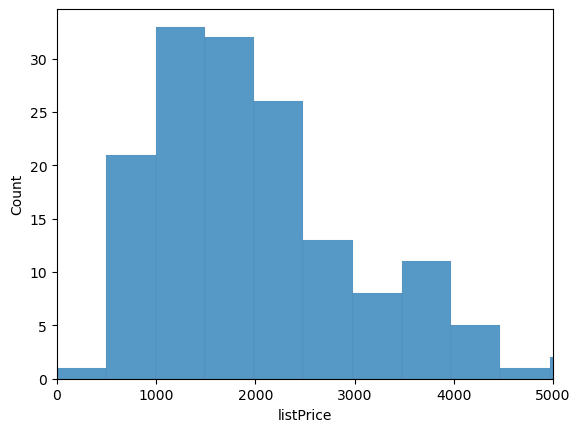

In [6]:
ax = sns.histplot(df, x='listPrice')
ax.set(xlim=[0, 5000])